# MLP final model analysis
Kristen Severson

This notebook performs analysis on the optimal MLP model (as determined in `Analyze_Results_MLP_CV.ipynb`).

Note that the training data is scaled differently than in the main notebook (the means are not subtracted such that zeros stay zero).

In [1]:
import glob
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
import pandas as pd
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
import torch
from torch import nn


Bad key "text.kerning_factor" on line 4 in
/Users/kristen.severson.ibm/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# set plotting settings
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'

figsize_1col = (3.25, 8.66) #ECS spec is 3.25" width
figsize_2col = (6.5, 4.33)

### Import data

In [3]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob('../data/' + folder + '/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l,1000,99))
    for k, file in enumerate(files):
        cell = np.genfromtxt(file,delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

In [4]:
train_data_raw = load_dataset('train')
test1_data_raw = load_dataset('test1')
test2_data_raw = load_dataset('test2')

In [5]:
train_out = torch.from_numpy(np.log10(np.genfromtxt('../data/cycle_lives/train_cycle_lives.csv'))).float()
test1_out = torch.from_numpy(np.log10(np.genfromtxt('../data/cycle_lives/test1_cycle_lives.csv'))).float()
test2_out = torch.from_numpy(np.log10(np.genfromtxt('../data/cycle_lives/test2_cycle_lives.csv'))).float()

### Create deltaVoltage Matrix
We can toggle between using normal and cycle-averaged input data using this boolean:

In [6]:
cycle_averaged = False

In [7]:
if not cycle_averaged:
    train_data = train_data_raw[:, ::10, 98] - train_data_raw[:, ::10, 8]
    test1_data = test1_data_raw[:, ::10, 98] - test1_data_raw[:, ::10, 8]
    test2_data = test2_data_raw[:, ::10, 98] - test2_data_raw[:, ::10, 8]

else:
    train_data = np.mean(train_data_raw[:, ::10, 96:99], axis=2) - np.mean(train_data_raw[:, ::10, 7:10], axis=2)
    test1_data = np.mean(test1_data_raw[:, ::10, 96:99], axis=2) - np.mean(test1_data_raw[:, ::10, 7:10], axis=2)
    test2_data = np.mean(test2_data_raw[:, ::10, 96:99], axis=2) - np.mean(test2_data_raw[:, ::10, 7:10], axis=2)

In [8]:
N, V = train_data.shape  #number of batteries, #number of voltage points, number of cycles

In [9]:
train_data = torch.from_numpy(train_data).float()
test1_data = torch.from_numpy(test1_data).float()
test2_data = torch.from_numpy(test2_data).float()

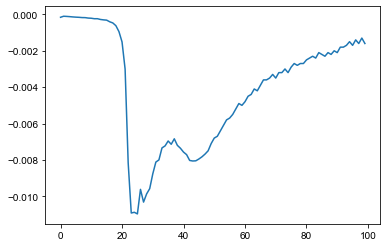

In [10]:
plt.plot(train_data[0])

In [11]:
means = torch.mean(train_data)
stdevs = torch.std(train_data) 

In [12]:
train_data = (train_data)/stdevs
test1_data = (test1_data)/stdevs
test2_data = (test2_data)/stdevs

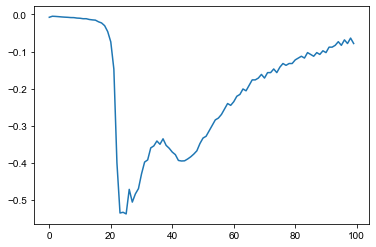

In [13]:
plt.plot(train_data[0])

Plot a few sample voltage matrices

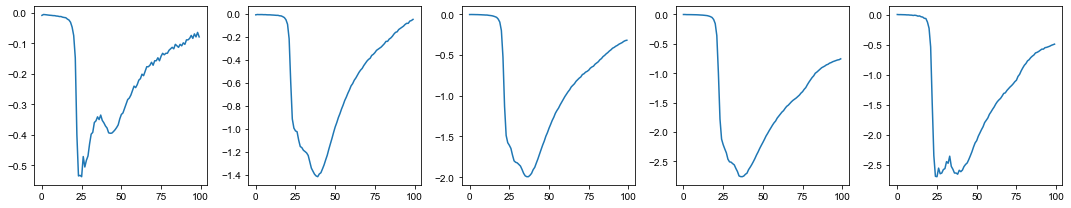

In [14]:
plot_idx = [0, 5, 12, 24, 38]
fig, axs = plt.subplots(1,5)
for i, ax, in enumerate(axs.flatten()):
    ax.plot(train_data[plot_idx[i]])
fig.set_size_inches(15,3)
fig.tight_layout()

tensor(-1.1138) tensor(1.)


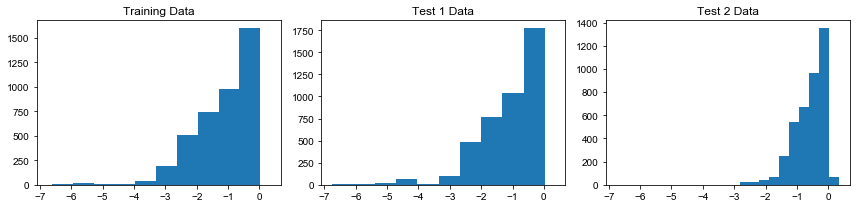

In [15]:
fig, axs = plt.subplots(1,3, sharex=True)
axs[0].hist(train_data.numpy().flatten())#,bins=np.arange(-7,0.1,0.05))
axs[0].set_title('Training Data')

axs[1].hist(test1_data.numpy().flatten())#,bins=np.arange(-7,0.1,0.05))
axs[1].set_title('Test 1 Data')

axs[2].hist(test2_data.numpy().flatten())#,bins=np.arange(-7,0.1,0.05))
axs[2].set_title('Test 2 Data')
print(torch.mean(train_data), torch.std(train_data))

fig.set_size_inches(12,3)
fig.tight_layout()

Center the log-cycle life (outputs)

In [16]:
out_means = torch.mean(train_out)

In [17]:
train_out = train_out - out_means
test1_out = test1_out - out_means
test2_out = test2_out - out_means

Text(0.5, 1.0, 'Training Output')

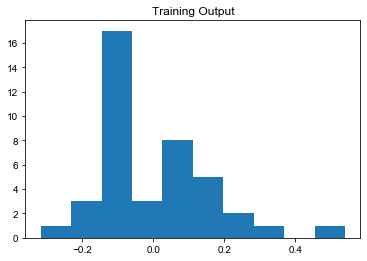

In [18]:
plt.hist(train_out.numpy())
plt.title('Training Output')

### Define Model and Supporting Functions

In [19]:
class MLP(nn.Module):
    def __init__(self, V, hidden_dim=256):
        super(MLP, self).__init__()
        lin1 = nn.Linear(V, hidden_dim)
        lin2 = nn.Linear(hidden_dim, hidden_dim)
        lin3 = nn.Linear(hidden_dim, 1)
        # add this for reproducibility
        torch.manual_seed(0)
        for lin in [lin1, lin2, lin3]:
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
        self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)
    def forward(self, input):
        out = input.view(input.shape[0], V)
        out = self._main(out)
        return out

In [20]:
def calc_loss(pred, obs):
    loss = nn.MSELoss()
    return loss(pred,obs)

In [21]:
def pretty_print(*values):
    col_width = 13
    def format_val(v):
        if not isinstance(v, str):
            v = np.array2string(v, precision=5, floatmode='fixed')
        return v.ljust(col_width)
    str_values = [format_val(v) for v in values]
    print("   ".join(str_values))

### Train model

This uses the best parameters from `Analyze_Results_MLP_CV.ipynb`

In [22]:
hd = 10
rw = 0.0001

#define learning rate
lr = 0.001


store_loss = []

step            train MSE       valid MSE    
0               2.39686      
1000            0.00499      
2000            0.00249      
3000            0.00154      
4000            0.00134      
5000            0.00112      
6000            0.00102      
7000            0.00097      
8000            0.00100      
9000            0.00076      


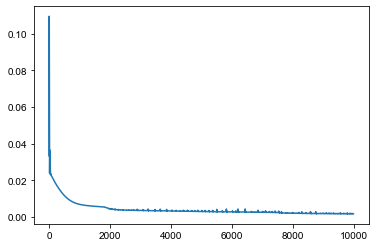

In [23]:
mlp = MLP(V, hd)
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

pretty_print('step', 'train MSE', 'valid MSE')
for step in range(10000):

    preds = mlp(train_data)
    train_err = calc_loss(preds.squeeze(), train_out)
    weight_norm = torch.tensor(0.)
    for w in mlp.parameters():
        weight_norm += w.norm().pow(2)

    loss = train_err.clone()
    loss += rw * weight_norm

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    store_loss.append(loss.item())

    if step % 1000 == 0:
        pretty_print(
        np.int32(step),
        train_err.detach().cpu().numpy()    
        )



plt.plot(store_loss[10:])

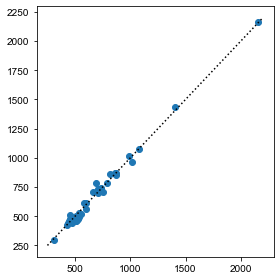

In [24]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)

ax.scatter(10**(mlp(train_data).detach()+out_means).numpy(),10**(train_out+out_means).numpy())
ax.plot(np.linspace(250,2200), np.linspace(250,2200), 'k:')

fig.tight_layout()

In [25]:
print(torch.sqrt(calc_loss(10**(mlp(train_data)+out_means).detach().squeeze(), 10**(train_out+out_means))))

tensor(32.1532)


### Calc test error

In [26]:
test1_data_no = torch.cat([test1_data[:21], test1_data[22:]])
test1_out_no = torch.cat([test1_out[:21], test1_out[22:]])

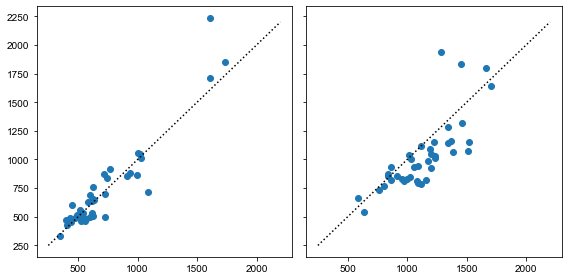

In [27]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True)
fig.set_size_inches(8,4)

ax[0].scatter(10**(mlp(test1_data_no)+out_means).detach().numpy().squeeze(),10**(test1_out_no+out_means).numpy())
ax[0].plot(np.linspace(250,2200), np.linspace(250,2200), 'k:')

ax[1].scatter(10**(mlp(test2_data)+out_means).detach().numpy().squeeze(),10**(test2_out + out_means).numpy())
ax[1].plot(np.linspace(250,2200), np.linspace(250,2200), 'k:')

fig.tight_layout()

In [28]:
print(torch.sqrt(calc_loss(10**(mlp(test1_data_no)+out_means).squeeze(), 10**(test1_out_no+out_means))), 
      torch.sqrt(calc_loss(10**(mlp(test2_data)+out_means).detach().squeeze(), 10**(test2_out + out_means))))

tensor(139.9220, grad_fn=<SqrtBackward>) tensor(218.4148)


## Explainability figure via SHAP

In [29]:
background =  train_data #train_data[np.random.choice(train_data.shape[0], 20, replace=False)]
explainer = shap.DeepExplainer(mlp, background)

In [30]:
shap_values = explainer.shap_values(torch.vstack((test1_data,test2_data)))
shap_values.shape

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(83, 100)

In [31]:
col_names = []
for i in np.linspace(2,3.6,100):
    col_names.append(str(np.round(i,3)))

Create shap importance vector as `y_shap`:

In [32]:
y_shap = np.mean(np.fliplr(shap_values), axis=0)

Text(0, 0.5, 'SHAP - Average impact of model output magnitude')

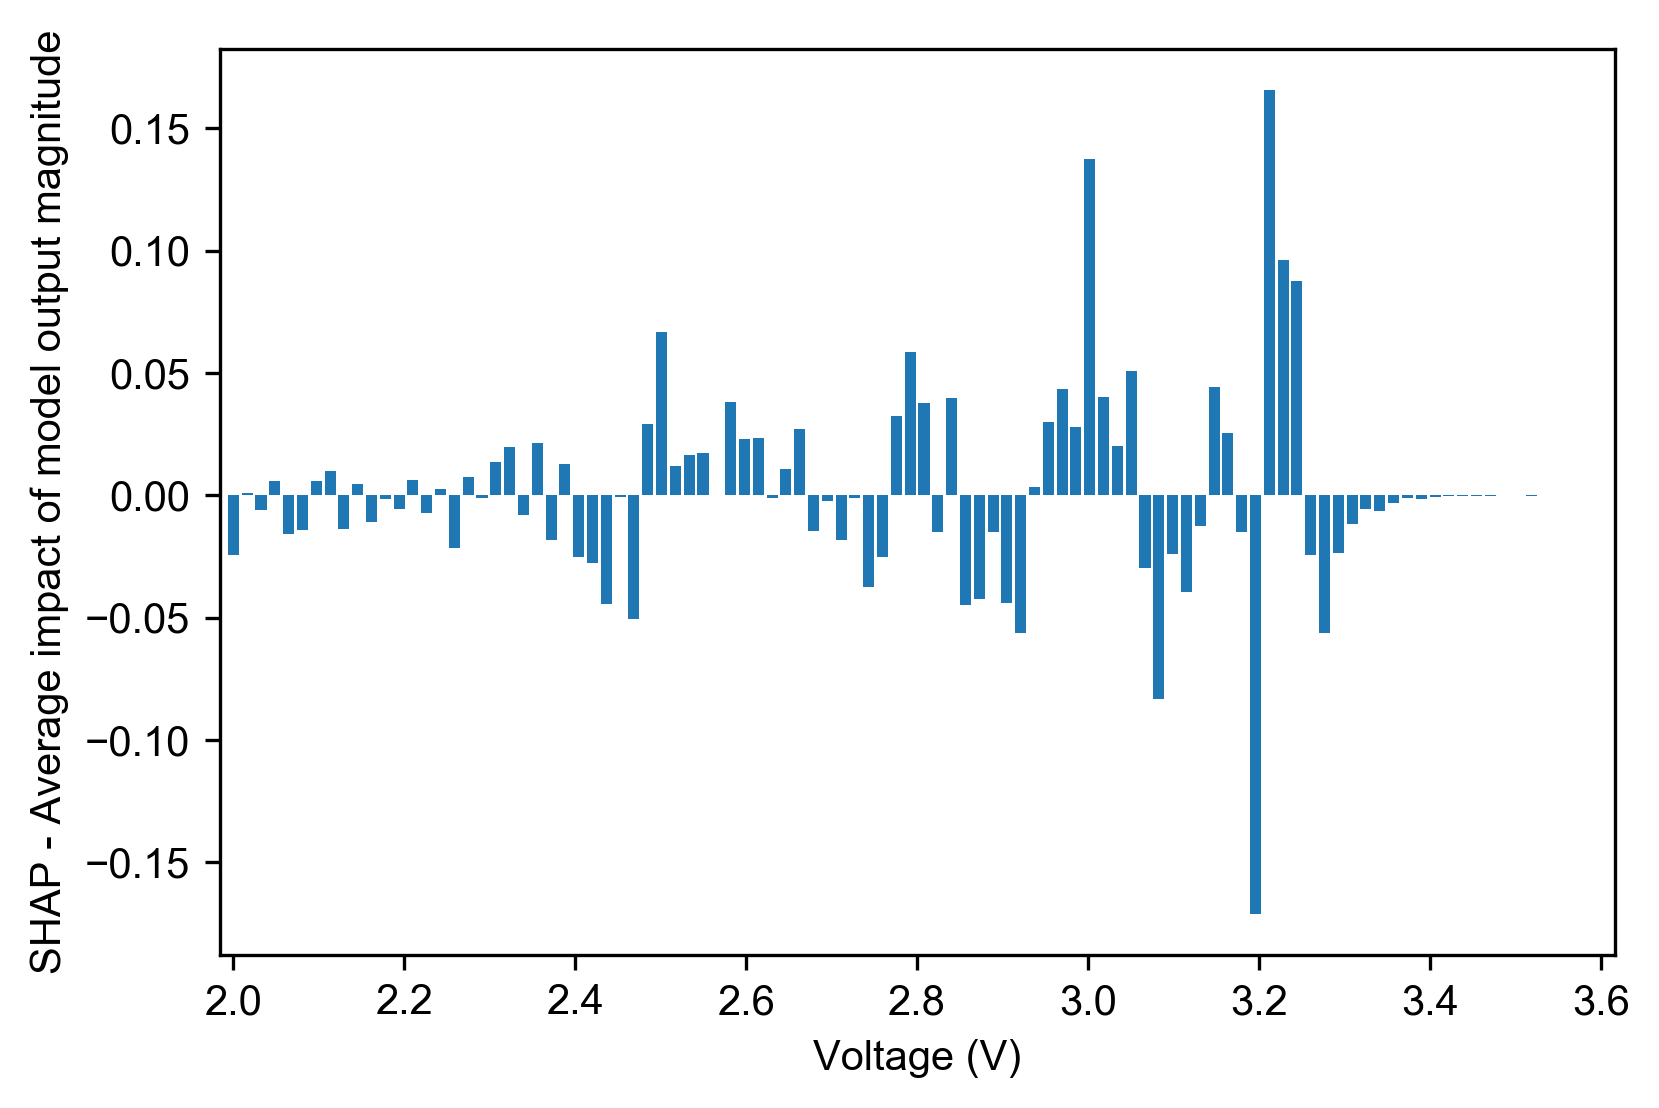

In [33]:
fig, ax = plt.subplots(1,1,dpi=300)
ax.bar(np.arange(100),y_shap)
ax.set_xticks(np.linspace(0,99,9))
ax.set_xlim([-1,100])
ax.set_xticklabels([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6])
#ax.set_ylim([0,0.25])
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('SHAP - Average impact of model output magnitude')

In [34]:
train_pred = 10**(mlp(train_data)+out_means).detach().squeeze()
train_res = train_pred - 10**(train_out+out_means)

test1_pred = 10**(mlp(test1_data_no)+out_means).squeeze()
test1_res = test1_pred - 10**(test1_out_no+out_means)

test2_pred = 10**(mlp(test2_data)+out_means).detach().squeeze()
test2_res = test2_pred - 10**(test2_out+out_means)

Save results:

In [35]:
file_name = 'mlp_predictions_cycavg.json' if cycle_averaged else 'mlp_predictions.json'

res_dict = {
    'train_pred': train_pred.tolist(),
    'test1_pred': test1_pred.tolist(),
    'test2_pred': test2_pred.tolist()}
with open(file_name, 'w') as outfile:
    json.dump(res_dict, outfile)

Save shap results:

In [36]:
if not cycle_averaged:
    np.savetxt('mlp_shap_results.csv', y_shap, fmt='%.3g', delimiter=',')